In [1]:
import subprocess
import time
import json
import pandas as pd
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from datetime import datetime

def get_gpu_stats():
    """Get comprehensive GPU statistics"""
    try:
        # Get GPU stats using nvidia-smi
        result = subprocess.run([
            'nvidia-smi', '--query-gpu=index,name,utilization.gpu,utilization.memory,memory.used,memory.total,temperature.gpu,power.draw,power.limit',
            '--format=csv,noheader,nounits'
        ], capture_output=True, text=True, check=True)
        
        lines = result.stdout.strip().split('\n')
        gpu_data = []
        
        for line in lines:
            parts = [part.strip() for part in line.split(',')]
            if len(parts) >= 9:
                gpu_data.append({
                    'GPU': int(parts[0]),
                    'Name': parts[1],
                    'GPU_Util_%': float(parts[2]) if parts[2] != '[Not Supported]' else 0,
                    'Mem_Util_%': float(parts[3]) if parts[3] != '[Not Supported]' else 0,
                    'Mem_Used_MB': float(parts[4]),
                    'Mem_Total_MB': float(parts[5]),
                    'Temp_C': float(parts[6]) if parts[6] != '[Not Supported]' else 0,
                    'Power_W': float(parts[7]) if parts[7] != '[Not Supported]' else 0,
                    'Power_Limit_W': float(parts[8]) if parts[8] != '[Not Supported]' else 0
                })
        
        return gpu_data
    except Exception as e:
        print(f"Error getting GPU stats: {e}")
        return []

def monitor_gpu(duration_minutes=60, refresh_seconds=2):
    """Monitor GPU utilization in real-time"""
    
    print("🚀 GPU Utilization Monitor - H200 Training Analysis")
    print("=" * 70)
    
    start_time = time.time()
    end_time = start_time + (duration_minutes * 60)
    
    # Store history for plotting
    history = []
    
    try:
        while time.time() < end_time:
            clear_output(wait=True)
            
            # Get current stats
            gpu_stats = get_gpu_stats()
            timestamp = datetime.now()
            
            if gpu_stats:
                # Add to history
                for gpu in gpu_stats:
                    gpu['timestamp'] = timestamp
                    history.append(gpu.copy())
                
                # Display current stats
                print("🚀 GPU Utilization Monitor - H200 Training Analysis")
                print("=" * 70)
                print(f"⏰ Monitoring Time: {(time.time() - start_time)/60:.1f}/{duration_minutes} minutes")
                print(f"🕐 Current Time: {timestamp.strftime('%H:%M:%S')}")
                print()
                
                for gpu in gpu_stats:
                    name = gpu['Name']
                    gpu_util = gpu['GPU_Util_%']
                    mem_used = gpu['Mem_Used_MB'] / 1024  # Convert to GB
                    mem_total = gpu['Mem_Total_MB'] / 1024
                    mem_percent = (mem_used / mem_total) * 100
                    temp = gpu['Temp_C']
                    power = gpu['Power_W']
                    power_limit = gpu['Power_Limit_W']
                    power_percent = (power / power_limit) * 100 if power_limit > 0 else 0
                    
                    print(f"🔥 GPU {gpu['GPU']}: {name}")
                    print(f"   💻 Compute Utilization: {gpu_util:6.1f}% {'🟢' if gpu_util > 90 else '🟡' if gpu_util > 70 else '🔴'}")
                    print(f"   🧠 Memory: {mem_used:6.1f}GB / {mem_total:6.1f}GB ({mem_percent:5.1f}%) {'🟢' if mem_percent > 95 else '🟡' if mem_percent > 80 else '🔴'}")
                    print(f"   🌡️  Temperature: {temp:5.1f}°C {'🟢' if temp < 80 else '🟡' if temp < 90 else '🔴'}")
                    print(f"   ⚡ Power: {power:6.1f}W / {power_limit:6.1f}W ({power_percent:5.1f}%) {'🟢' if power_percent > 80 else '🟡' if power_percent > 60 else '🔴'}")
                    print()
                
                # Analysis
                avg_gpu_util = sum(gpu['GPU_Util_%'] for gpu in gpu_stats) / len(gpu_stats)
                avg_mem_util = sum((gpu['Mem_Used_MB']/gpu['Mem_Total_MB'])*100 for gpu in gpu_stats) / len(gpu_stats)
                
                print("📊 UTILIZATION ANALYSIS:")
                if avg_gpu_util > 90 and avg_mem_util > 95:
                    print("   ✅ EXCELLENT: GPU is fully utilized!")
                elif avg_gpu_util > 70 and avg_mem_util > 80:
                    print("   ⚠️  GOOD: GPU is well utilized but could be optimized")
                else:
                    print("   ❌ UNDERUTILIZED: GPU has significant unused capacity")
                
                print(f"   📈 Average GPU Compute: {avg_gpu_util:.1f}%")
                print(f"   💾 Average Memory Usage: {avg_mem_util:.1f}%")
                
                # Training efficiency indicators
                if avg_gpu_util < 70:
                    print("\n🔧 OPTIMIZATION SUGGESTIONS:")
                    print("   • Increase batch size")
                    print("   • Reduce gradient accumulation steps")
                    print("   • Check if CPU is bottlenecking data loading")
                    print("   • Increase dataloader workers")
                
                # Keep only last 100 data points for plotting
                if len(history) > 100:
                    history = history[-100:]
                    
            else:
                print("❌ Could not retrieve GPU statistics")
            
            time.sleep(refresh_seconds)
            
    except KeyboardInterrupt:
        print("\n⏹️  Monitoring stopped by user")
    
    # Plot summary if we have history
    if len(history) > 5:
        plot_utilization_summary(history)

def plot_utilization_summary(history):
    """Plot utilization summary"""
    clear_output(wait=True)
    
    df = pd.DataFrame(history)
    
    if not df.empty:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('H200 GPU Utilization Summary', fontsize=16)
        
        # GPU Utilization
        axes[0,0].plot(df['timestamp'], df['GPU_Util_%'], 'b-', linewidth=2)
        axes[0,0].set_title('GPU Compute Utilization (%)')
        axes[0,0].set_ylabel('Utilization %')
        axes[0,0].grid(True, alpha=0.3)
        axes[0,0].axhline(y=90, color='g', linestyle='--', alpha=0.7, label='Target >90%')
        axes[0,0].legend()
        
        # Memory Utilization
        mem_percent = (df['Mem_Used_MB'] / df['Mem_Total_MB']) * 100
        axes[0,1].plot(df['timestamp'], mem_percent, 'r-', linewidth=2)
        axes[0,1].set_title('Memory Utilization (%)')
        axes[0,1].set_ylabel('Memory %')
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].axhline(y=95, color='g', linestyle='--', alpha=0.7, label='Target >95%')
        axes[0,1].legend()
        
        # Temperature
        axes[1,0].plot(df['timestamp'], df['Temp_C'], 'orange', linewidth=2)
        axes[1,0].set_title('Temperature (°C)')
        axes[1,0].set_ylabel('Temperature °C')
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].axhline(y=80, color='r', linestyle='--', alpha=0.7, label='Caution >80°C')
        axes[1,0].legend()
        
        # Power Usage
        power_percent = (df['Power_W'] / df['Power_Limit_W']) * 100
        axes[1,1].plot(df['timestamp'], power_percent, 'purple', linewidth=2)
        axes[1,1].set_title('Power Usage (%)')
        axes[1,1].set_ylabel('Power %')
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].axhline(y=80, color='g', linestyle='--', alpha=0.7, label='Target >80%')
        axes[1,1].legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\n📊 TRAINING SESSION SUMMARY:")
        print("=" * 50)
        print(f"Average GPU Utilization: {df['GPU_Util_%'].mean():.1f}% (Target: >90%)")
        print(f"Average Memory Usage: {mem_percent.mean():.1f}% (Target: >95%)")
        print(f"Average Temperature: {df['Temp_C'].mean():.1f}°C (Safe: <80°C)")
        print(f"Average Power Usage: {power_percent.mean():.1f}% (Target: >80%)")
        print(f"Max Memory Used: {df['Mem_Used_MB'].max()/1024:.1f}GB")

# Quick one-time check function
def quick_check():
    """Quick one-time GPU status check"""
    gpu_stats = get_gpu_stats()
    
    if gpu_stats:
        for gpu in gpu_stats:
            mem_used_gb = gpu['Mem_Used_MB'] / 1024
            mem_total_gb = gpu['Mem_Total_MB'] / 1024
            mem_percent = (mem_used_gb / mem_total_gb) * 100
            
            print(f"🔥 GPU {gpu['GPU']}: {gpu['Name']}")
            print(f"   💻 Compute: {gpu['GPU_Util_%']:.1f}%")
            print(f"   🧠 Memory: {mem_used_gb:.1f}GB/{mem_total_gb:.1f}GB ({mem_percent:.1f}%)")
            print(f"   🌡️  Temp: {gpu['Temp_C']:.1f}°C")
            print(f"   ⚡ Power: {gpu['Power_W']:.1f}W")

# Usage examples:
print("🚀 H200 GPU Monitor Ready!")
print("\nUsage:")
print("quick_check()           # One-time status check")
print("monitor_gpu(30, 2)      # Monitor for 30 minutes, refresh every 2 seconds")
print("monitor_gpu(60)         # Monitor for 1 hour with default settings")

🚀 H200 GPU Monitor Ready!

Usage:
quick_check()           # One-time status check
monitor_gpu(30, 2)      # Monitor for 30 minutes, refresh every 2 seconds
monitor_gpu(60)         # Monitor for 1 hour with default settings


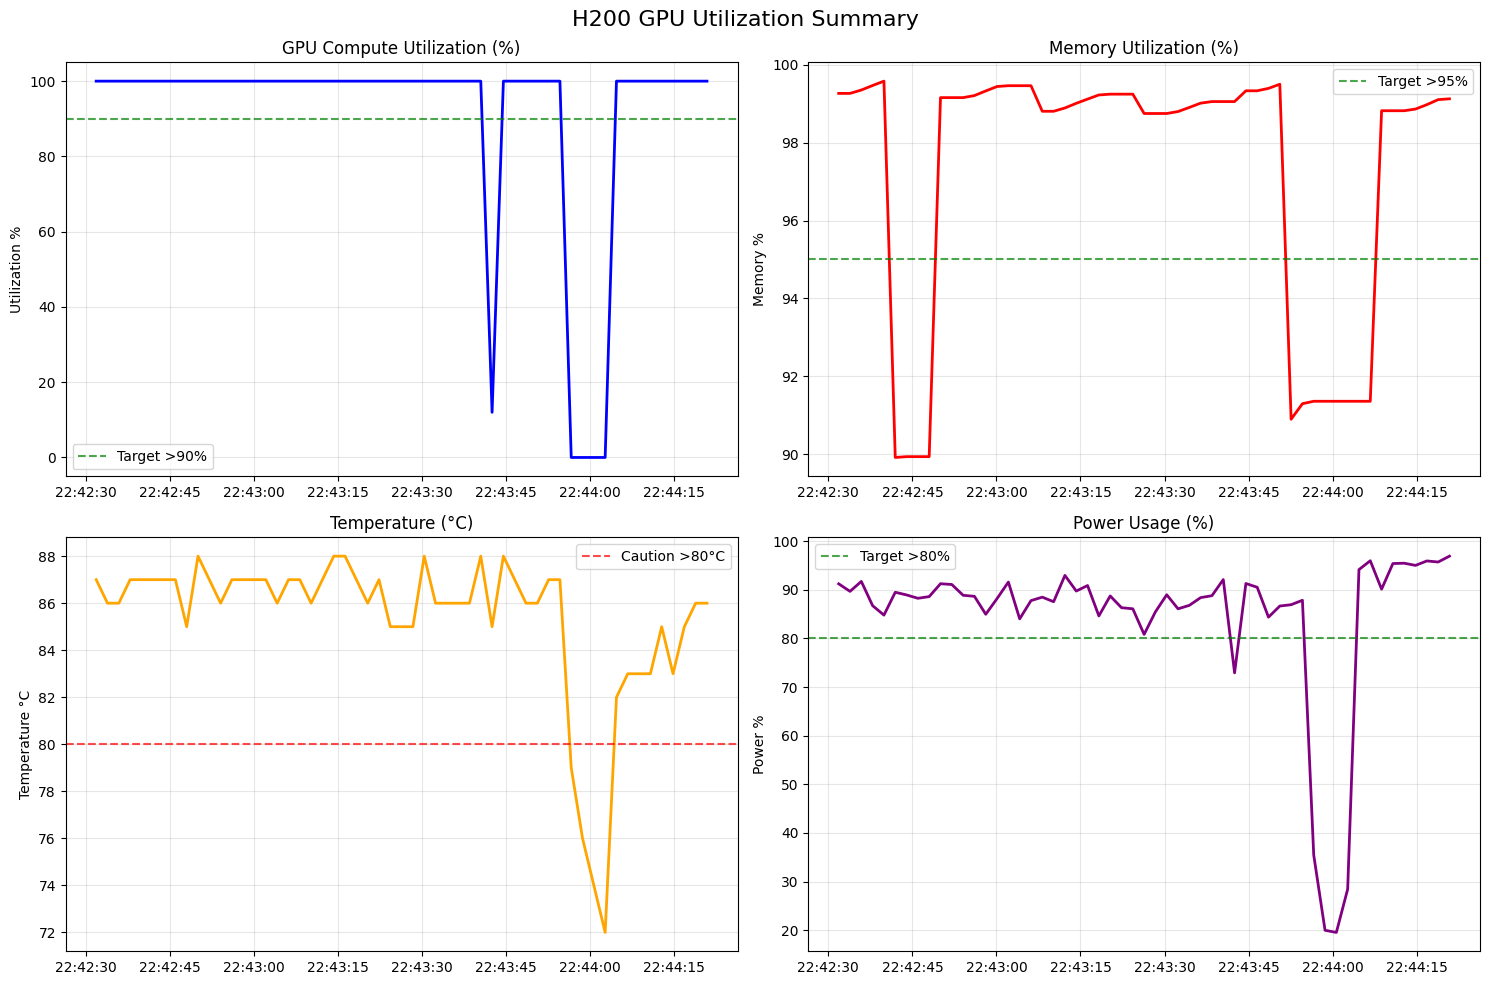


📊 TRAINING SESSION SUMMARY:
Average GPU Utilization: 91.1% (Target: >90%)
Average Memory Usage: 97.3% (Target: >95%)
Average Temperature: 85.4°C (Safe: <80°C)
Average Power Usage: 84.5% (Target: >80%)
Max Memory Used: 139.8GB


In [2]:
monitor_gpu(30, 2) 